**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a uniform distribution.

$$ \lambda^+ = \lambda - (\frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p)*(dB/dW), p \sim \mathcal{N}(\mu = 0, \sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

This is based off of a ***simple random search*** algorithm

$$ u^+ = u - \frac{\gamma}{N \Delta} \sum_{n = 1}^N ( c(u + \Delta u_n) - c(u) ) \cdot u_n,\ u_n \sim \mathcal{N}(u,\sigma^2) $$

(See [3] for random search/stochastic gradient descent reference)

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.

[3] Y. Nesterov and V. Spokoiny, “Random Gradient-Free Minimization of Convex Functions,” Found Comput Math, vol. 17, no. 2, pp. 527–566, Apr. 2017, doi: 10.1007/s10208-015-9296-2.



__Test Cases:__

1. Try ideal scenario: KW = Identity matrix, A = 0, B = 0
2. Limit number of neurons to 2
3. Test SGD against simple cost function ($y = x^2$)
4. Ideal scenario with A/B: KW = I, A - Kb = 0

In [1]:
import numpy as np
import sys
import os
from numpy import linalg, matlib
# save, import and load data
from numpy import asarray, save, load
# needed for some matrix manipulations
import matplotlib.pyplot as plt
# for plots
import seaborn
# to get date for saving data
from datetime import date    


# set up seaborn for the plots
seaborn.set()


In [2]:
# parent_dir = os.getcwd()
parent_dir = '/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model'
# # define the name of the directory to be created
today = date.today().isoformat()
today_path = parent_dir + "/data/" + today
print(today_path)


try:
    # Recursive directory creation function. 
    # Like mkdir(), but makes all intermediate-level directories needed to contain the leaf directory.
    os.makedirs(today_path)
except OSError:
    print ("Directory %s already exists" % today_path)
else:
    print ("Successfully created the directory %s " % today_path)


/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/data/2020-09-27
Directory /Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/data/2020-09-27 already exists


In [3]:
# change directory 
os.chdir(today_path)

In [4]:
os.getcwd()

'/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/data/2020-09-27'

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Brain Modeling

In [6]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect, 0, 1)
    newFR = np.matmul(lambda_vect, targ_vect_mult)
    return newFR[:, np.newaxis]

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# brainFiringRate(lambda_vect, targ_vect) = b + Wt
#********


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1  
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    
    # dimensions of neurons and lambda matrix
    num_neurons = np.size(lambda_vect, 0)
    num_lambda = np.size(lambda_vect, 1)
    
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    targ_vect_mult = np.insert(targ_vect, 0, 1) # 3 x 1
    
    # Repeated the target vector NUM_NUERONS times to get a N x 3 matrix with the rows = [1 t_x t_y]
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3
    
    # each neuron has a stochastic perturbation term that is used to multiply the target vector 
    # See Eq 6 of Heliot et al, 2010
    delta_matx = np.matlib.repmat(delta_perturb, 1, num_lambda) # N x 3
    
    # Element-wise multiplication to find the update term for gamma
    next_term = (delta_matx*targ_matx) # N x 3

    # next gradient term: \gamma*delta_perturb
    lambda_vect_new = lambda_vect - (gamma*next_term)
    
     # NOTE: dimensions are going to be annoying here
    if (KW_ONLY):
        lambda_vect_new[:, 0] = 0
        
    return lambda_vect_new


#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# gamma = 0.5
# delta_perturb = np.array([[4], [5], [6], [7]])
# calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect) = lambda_vect - (gamma*error grad*[1 tx ty])
#********

# def calcNextBrain_old(brain_params, decoder_params, cost_func, targ_vect):
    
#     # Unpack arguments that are being passed in
#     (fr_curr, fr_dist, lambda_curr, lambda_rate) = brain_params
#     (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
#     decoder_vals = (a_vect, k_matx)
#     # set cost function arguments
#     # fr_curr, targ_vect, lambda_curr = brain_vars
#     cost_func_args = ( (a_vect, k_matx), (fr_curr, targ_vect, lambda_curr))
#     # set the vectors for the next value
#     fr_next = np.zeros(np.shape(fr_curr))
#     lambda_next = np.zeros(np.shape(lambda_curr))

#      # (1) calculate the perturbation
#     fr_grad = findErrorGrad(fr_curr, FR_VAR, fr_dist, cost_func, cost_func_args)
    
#     # (2) Find next lambda
#     lambda_next = calcNextLambda(lambda_curr, lambda_rate, fr_grad, targ_vect)
    
#     # (3) fr+ = B(lambda+)
#     fr_next = brainFiringRate(lambda_next, targ_vect)
    
#     return  (fr_next, lambda_next)


# TODO: see if the baseline scalar value is affecting the cost function 
def calcNextBrain(brain_params, decoder_params, cost_func, targ_vect):
    
    # Unpack arguments that are being passed in
    (fr_curr, fr_dist, lambda_curr, lambda_rate, l_dist) = brain_params
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params

    # set cost function arguments
    cost_func_args = ( (a_vect, k_matx), (fr_curr, targ_vect, lambda_curr))
    
    # set the vectors for the next value
    fr_next = np.zeros(np.shape(fr_curr))
    lambda_next = np.zeros(np.shape(lambda_curr))

     # (1) calculate the perturbation
    lambda_grad = findErrorGrad(lambda_curr, L_VAR, l_dist, cost_func, cost_func_args)
    
    # (2) Find next lambda
    lambda_next = lambda_curr - lambda_rate*lambda_grad
    
    # (3) fr+ = B(lambda+)
    fr_next = brainFiringRate(lambda_next, targ_vect)
        
    if (KW_ONLY):
        # set baseline to 0
        lambda_next[:, 0] = 0
        
    return  (fr_next, lambda_next)


### Decoder Model

In [7]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# brain_params = fr_curr, target position, current lambda value
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # un-nests the input values
    (a_vect, k_matx) = decoder_params
    (fr_curr, targ, lamdba_curr) = brain_params
    
    num_dim = np.shape(targ)
    
    # sets the dimensions for cursor position
    cursor_pos = np.zeros(num_dim)
    # reshape added to ensure that the a_vect is the correct dimensions
    # Y = D(f) = a + Kf --> Weiner Filter
    cursor_pos = a_vect.reshape(num_dim) +  (np.matmul(k_matx, fr_curr))
    return (cursor_pos)

#********
# Passed Test: 
# a = np.array([-10, -20])
# k = np.random.random([2, 4])
# NUM_DIM = 2
# fr = brainFiringRate(lambda_vect, targ_vect)
# decoder_params = (a, k)
# brain_params = (fr, targ_vect)
# pos = decoder_findY(decoder_params, brain_params) = a + Kf
#********

DECODER_ADAPT = True

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
    
def calcNextDecoder(decoder_params, brain_vars, cost_func):
    
    # un-nests parameters
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    
    if (DECODER_ADAPT == True):
        # if decoder adaptation is true, update the A and K parameters of the brain
        a_grad = findErrorGrad(a_vect, A_VAR, a_dist, cost_func, cost_func_args)
        k_grad = findErrorGrad(k_matx, K_VAR, k_dist, cost_func, cost_func_args)
        a_next = a_vect.reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx - k_rate*k_grad
    else:
        # if DECODER_ADAPT == False (so no decoder adaptation), return the same a_vector and K_matrix
        a_next = a_vect
        k_next = k_matx
        
    if (KW_ONLY):
        a_next = np.zeros(np.shape(a_vect))
        
    return (a_next, k_next)


#*******
# TODO: Test this function
#*******


### Reach Error

Joint cost = reach error + brain penalty cost + decoder penalty cost

reach error = $||y-\tau||^2 $

brain cost = $||y-\tau||^2  + \sigma_{w}||W||^2$

decoder cost = $||y-\tau||^2 + \sigma_{k}||K||^2$

Joint cost = brain cost + decoder cost = 2$||y-\tau||^2 + \sigma_{w}||W||^2 + \sigma_{k}||K||^2$

In [8]:
SIGMA = .5
# sigma/variance of target < 1
# sigma/(target^2) < 1

In [9]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# this returns the square of distance between the two position points
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect).reshape(NUM_DIM,1) - np.array(t_vect).reshape(NUM_DIM, 1)
    return (np.linalg.norm(norm_vect, 2)**2)

#*******
# Failed test:
# Had to add .reshape(NUM_DIM, 1) to the norm vect
# Update:
# Passed Test
#*******

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def reach_cost(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect, lambda_curr) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect.copy()
    return calcReachError(y_vect, t_vect)  

def brain_cost(cost_func_params):
    # parameters
    sig_b = SIGMA #sigma for brain matrix W
    
    # un-pack params to get W
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect, lambda_curr) = brain_vars
    
    # calc brain regularization term
    w_matx = lambda_curr[:, 1:NUM_LAMBDA]
    brain_penalty = sig_b*(np.linalg.norm(w_matx,2)**2)
    
    # add brain penalty to reach error
    cost = reach_cost(cost_func_params) + brain_penalty
    return cost 

def decoder_cost(cost_func_params):
    # parameters
    sig_k = SIGMA #sigma for decoder matrix K

    # un-pack params to get K 
    (decoder_params, brain_vars) = cost_func_params
    (a_vect, k_matx) = decoder_params
    
    # calc decoder regularization term
    dec_penalty = sig_k*(np.linalg.norm(k_matx,2)**2)
    cost = reach_cost(cost_func_params) + dec_penalty 
    return cost   

def joint_cost(cost_func_params):
     # parameters
    sig_b = SIGMA #sigma for brain matrix W
    sig_k = SIGMA #sigma for decoder matrix K
    
    # un-pack params to get K and W
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect, lambda_curr) = brain_vars
    (a_vect, k_matx) = decoder_params
    
    # brain penalty term
    w_matx = lambda_curr[:, 1:NUM_LAMBDA]
    brain_cost = sig_b*(np.linalg.norm(w_matx,2)**2)
    
    # decoder penalty term
    dec_cost = sig_k*(np.linalg.norm(k_matx,2)**2)
  
    return reach_cost(cost_func_params) + brain_cost + dec_cost

## NOTES ABOUT THIS
# 09/20/2020: confirmed that the np.linalg.norm(matx, 2) returns the magnitude -- anyway, neither matrix is ever <0

### Stochastic Error Descent: Update Calculation

In [10]:
import random
import time

## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect, curr_lambda) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
#     perturb_rand = np.random.uniform(-sigma, sigma, [num_input_row, num_input_column, num_dist])
    perturb_rand = np.random.normal(0, sigma, [num_input_row, num_input_column, num_dist])

# Normalizes the stochastic perturbations to 1 and then multiplies by sigma, so perturb_rand = +/- sigma
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect, curr_lambda) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect, curr_lambda))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect, curr_lambda))
        
        # default: do nothing
        elif (input_var == L_VAR):
            if (KW_ONLY):
                input_perturb[:, 0] = 0
            fr_perturb = brainFiringRate(input_perturb, targ_vect)
            perturb_cost_args = (decoder_params, (fr_perturb, targ_vect, input_perturb))
            
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

#     error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad

### Stochastic Gradient Descent: Update Step and Recalculate Error

### Generate New Trial

In [11]:
# def findNextTarget(curr_cursor, prev_targ):
#     ## random
#     x_pos = int(np.random.random_sample()*10)
#     y_pos = int(np.random.random_sample()*10)

#     return np.array( [x_pos, y_pos] )

def findNextTarget(curr_cursor, prev_targ):
    ## random
#     x_pos = 2*np.random.random_sample()
    x_pos = 1
    if np.random.random() < 0.5:
        x_pos = -1

    return np.array( [x_pos] )

### Set initial conditions

In [12]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

KW_ONLY = True #False = include A/B, True = only K/W, no baseline

# ## Save initial conditions
filename = str(today) + '_INITIAL_CONDITIONS.txt'
print(filename)
stdout_fileno = sys.stdout
sys.stdout = open(filename, "w")
    
NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("=========================================")
print("INITIAL CONDITIONS")
print("=========================================")

print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
# TARGET_VECTOR = np.array([[1] , [1]])
TARGET_VECTOR = np.array([[1]])
print("dimensions of target = " + str(np.shape(TARGET_VECTOR)))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (0*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
# K_MATX = 10*np.random.random_sample((NUM_DIM, NUM_NEURONS)) # random float [0, 1)
K_MATX = (1)*np.ones((NUM_DIM, NUM_NEURONS)) # random float [0, 1)
# A_VECT = (-np.matmul(K_MATX, BASELINE))
A_VECT = -np.random.random_sample((NUM_DIM))*0
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
# W_init = 0*np.linalg.pinv(K_MATX) 
# W_rand = np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
# W_init = W_init + W_rand
# W_init = 10*np.random.random_sample((NUM_NEURONS, NUM_DIM))
W_init = (1)*np.ones((NUM_NEURONS, NUM_DIM))
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:NUM_LAMBDA] = W_init
print("lambda init = ")
print(lambda_init)


# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3
L_VAR = 4

SIGMA_GAUSSIAN = 5e-2
SGD_DELTA = 1

# Brain
FR_SIGMA = SIGMA_GAUSSIAN
FR_DELTA = SGD_DELTA
FR_DIST_SIZE = 1
print("")
print("-------------------------------------------")
print("FR DISTRIBUTION")
print("FR_SIGMA = " + str(FR_SIGMA))
print("FR_DELTA = " + str(FR_DELTA))
print("FR_DIST_SIZE = " + str(FR_DIST_SIZE))


L_SIGMA = SIGMA_GAUSSIAN
L_DELTA = SGD_DELTA
L_DIST_SIZE = 1
print("")
print("-------------------------------------------")
print("LAMBDA DISTRIBUTION")
print("L_SIGMA = " + str(FR_SIGMA))
print("L_DELTA = " + str(FR_DELTA))
print("L_DIST_SIZE = " + str(FR_DIST_SIZE))


# Decoder
# A_RATE = 1e-4
A_SIGMA = SIGMA_GAUSSIAN
A_DELTA = SGD_DELTA
A_DIST_SIZE = 1
print("")
print("A DISTRIBUTION")
print("A_SIGMA = " + str(A_SIGMA))
print("A_DELTA = " + str(A_DELTA))
print("A_DIST_SIZE = " + str(A_DIST_SIZE))
# --
# K_RATE = 5e-4
K_SIGMA = SIGMA_GAUSSIAN
K_DELTA = SGD_DELTA
K_DIST_SIZE = 1
print("")
print("K DISTRIBUTION")
print("K_SIGMA = " + str(K_SIGMA))
print("K_DELTA = " + str(K_DELTA))
print("K_DIST_SIZE = " + str(K_DIST_SIZE))
# display parameters
# fig_x = 10
# fig_y = 5

# cost function
JOINT_COST = joint_cost
BRAIN_COST = brain_cost
DECODER_COST = decoder_cost

sys.stdout.close()
## Restore sys.stdout to our old saved file handler
sys.stdout = stdout_fileno

2020-09-27_INITIAL_CONDITIONS.txt


## Learning Rates

In [13]:
BRAIN_ADAPT = True
# SIGMA_GAUSSIAN = 1e-1

NUM_TRIALS = 100

# NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trial for target once
NUM_SESSIONS = 1
rate_list = [.3]
# rate_list = [3e-4]
print(rate_list)
# dec_rate_list = (np.logspace(-2, -6, 11))
dec_rate_list = rate_list
# K_RATE = 1e-4
NUM_B_RATE = len(rate_list)
print("NUM_B_RATE = " + str(NUM_B_RATE))
NUM_D_RATE = len(dec_rate_list)
print("NUM_D_RATE = " + str(NUM_D_RATE))
ADAPT_TRIALS = NUM_TRIALS

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
# Note to self: last NUM_TRIALS element of target_trial is not run
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
cost_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
cost_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
b_cost = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
d_cost = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_cost = np.zeros((NUM_TRIALS, NUM_SESSIONS))

[0.3]
NUM_B_RATE = 1
NUM_D_RATE = 1


In [14]:
def saveExperimentToFile(filename):
    ## SAVE README
    
    stdout_fileno = sys.stdout
    sys.stdout = open(filename + '_README.txt', "w")

    print("=========================================")
    print("EXPERIMENT DETAILS")
    print("=========================================")
    print("Adaptive Decoder = " + str(DECODER_ADAPT))
    print("Adaptive Brain = " + str(BRAIN_ADAPT))
    print("KW only = " + str(KW_ONLY))
    print("Total Number of Trials = " + str(NUM_TRIALS))
    print("Total Number of Sessions = " + str(NUM_SESSIONS))
#     print("Total Number of Runs = " + str(NUM_RUNS))
    print("Brain Learning Rate = " + str(lambda_rate))
    print("NUM_B_RATE = " + str(NUM_B_RATE))
    print("Decoder (K) Learning Rate = " + str(K_RATE))
    print("Decoder (A) Learning Rate = " + str(A_RATE))
    print("NUM_D_RATE = " + str(NUM_D_RATE))
    print("=========================================")

    sys.stdout.close()
    # Restore sys.stdout to our old saved file handler
    sys.stdout = stdout_fileno

    ## SAVE PARAMETERS
    np.savez(filename + '_Parameters.npz', num_trials=NUM_TRIALS, num_sessions=NUM_SESSIONS, 
     num_neurons=NUM_NEURONS, num_dim=NUM_DIM, num_lambda=NUM_LAMBDA,
     decoder_adapt=DECODER_ADAPT, brain_adapt=BRAIN_ADAPT, brain_rate=lambda_rate, 
     k_rate=K_RATE, a_rate=A_RATE, num_b_rate=NUM_B_RATE, num_d_rate=NUM_D_RATE, b_rate_list=rate_list, d_rate_list=dec_rate_list)


+++++++++++++++++++++++++++++++++++
Session #0
Session Start
brain rate = 0.3
decoder rate = 0.3

--------------------
Session #0
Session End


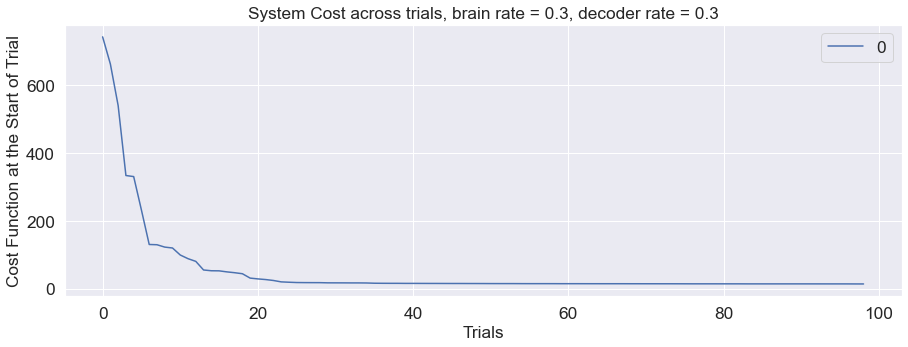

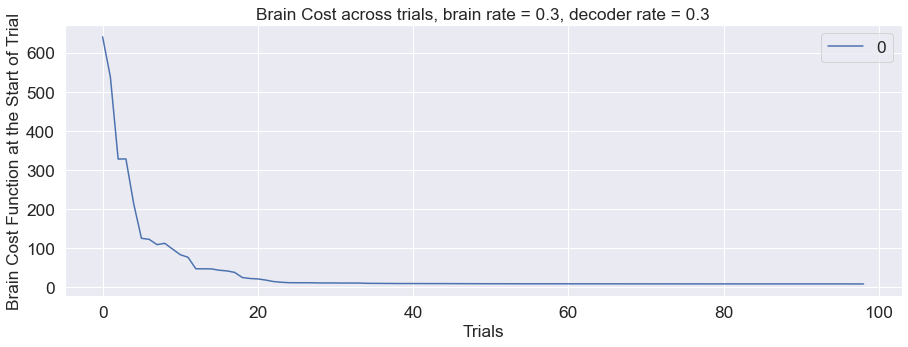

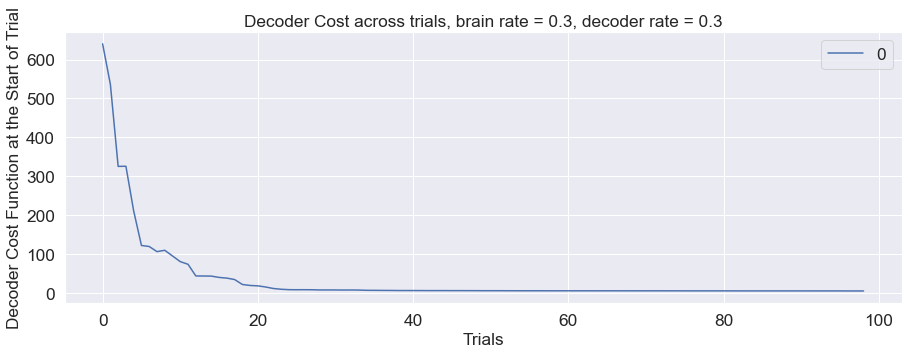

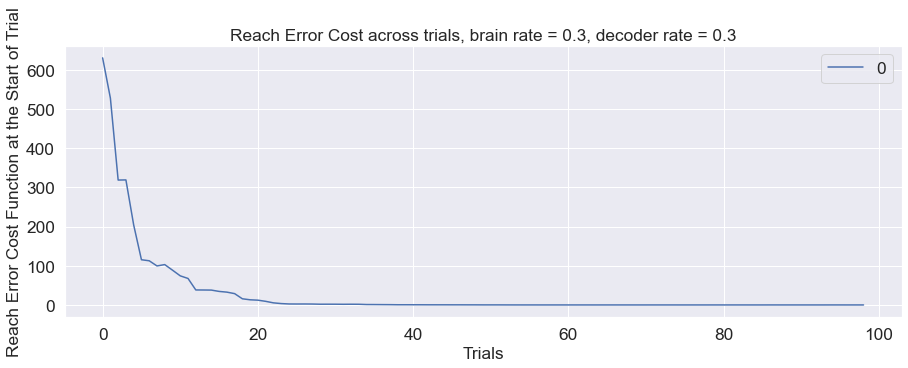

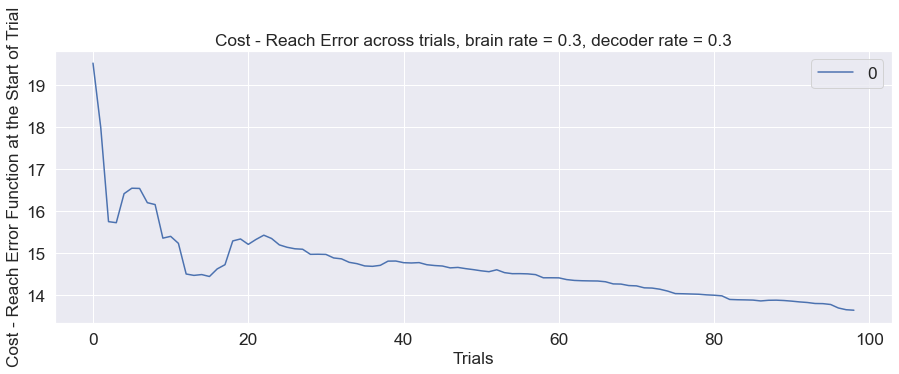

In [15]:
pidx = 0
n_fig = 5
for lambda_rate in rate_list:
    for dec_rate in dec_rate_list:
        A_RATE = dec_rate
        K_RATE = dec_rate    
        
        datafile = str(today) + '_BRAIN_ADAPT_' + str(BRAIN_ADAPT) + '_BRAIN_RATE_' + str(lambda_rate) + '_DEC_ADAPT_'+ str(DECODER_ADAPT) + '_K_RATE_' + str(dec_rate) + '_A_RATE_' + str(dec_rate)
        saveExperimentToFile(datafile)

        for iS in range(NUM_SESSIONS):
            print("")
            print("+++++++++++++++++++++++++++++++++++")
            print("Session #" + str(iS))
            print("Session Start")
            print("brain rate = " + str(lambda_rate))
            print("decoder rate = " + str(dec_rate))
            ## BRAIN SIDE
            FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
            L_DIST = (L_SIGMA, L_DELTA, L_DIST_SIZE)

            ## DECODER SIDE
            A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
            K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

            # target position -- new target represents a new trial
            target_trial[:, :, 0, iS] = TARGET_VECTOR
            
            ## VECTORS FOR TRIALS    
            lambda_trial[:, :, 0, iS] = lambda_init
            a_trial[:, 0, iS] = np.array(A_VECT)
            k_trial[:,:, 0, iS] = K_MATX
            decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
            decoder_vals = (A_VECT, K_MATX)

            for iT in range(NUM_TRIALS-1):
#                 print("")
#                 print("=========================================")
#                 print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
#                 print("Target = " + str(target_trial[:, :, iT, iS]))

                # calculate firing rate given lambda and decoder parameters with current target position 
                fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
                fr_trial[:, :, iT] = fr_start

                # calculate reach error of firing rate at the beginning of the trial
                # this becomes the error of the new target position being presented and where the cursor is
                brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS], lambda_trial[:, :, iT, iS] )
                cost_func_params = (decoder_vals, brain_vars) 

                cost_startT[iT, iS] = JOINT_COST(cost_func_params)

                cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))

                # Run through trial and see the reach at the end        
                # current brain and decoder params
                brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate, L_DIST)
                decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

                # adapt brain and decoder (together here)
                a_run, k_run = calcNextDecoder(decoder_params, brain_vars, DECODER_COST)
                
                if (BRAIN_ADAPT):
                    fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, BRAIN_COST, target_trial[:, :, iT, iS])
                else:
                    fr_run = fr_trial[:, :, iT]
                    lambda_run = lambda_trial[:, :, iT, iS]
                    
                if (KW_ONLY):
                    a_run = np.zeros((NUM_DIM, 1))
                    lambda_run[:, 0] = 0

                # update cost function arguments
                decoder_vals = (a_run, k_run)
                brain_vars = (fr_run, target_trial[:, :, iT, iS], lambda_run)
                # see how the updated decoder and brain paramters have done with the current
                # target position (so target at trial = iT)
                cost_func_params = (decoder_vals, brain_vars) 
#                 cost_run = np.array(JOINT_COST(cost_func_params))
                cost_run = JOINT_COST(cost_func_params)
                    
                cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))

                cost_endT[iT, iS] = cost_run
                b_cost[iT, iS] = BRAIN_COST(cost_func_params)
                d_cost[iT, iS] = DECODER_COST(cost_func_params)
                re_cost[iT, iS] = reach_cost(cost_func_params)

                # update the parameters
                lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)

                a_trial[:, iT + 1, iS] = np.squeeze(a_run)
                k_trial[:, :, iT + 1, iS] = (k_run)
                
                # change to new target
                target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )

            plt.figure(n_fig*pidx + 1) #, figsize=(fig_x, fig_y))
            plt.plot(np.arange(0, NUM_TRIALS-1, 1), cost_startT[0:len(cost_startT)-1, iS], label = '' + str(iS))
            plt.legend()
            plt.xlabel('Trials')
            plt.ylabel('Cost Function at the Start of Trial')
            plt.title('System Cost across trials, brain rate = ' + str(lambda_rate) + ", decoder rate = " + str(dec_rate))
            
            plt.figure(n_fig*pidx + 2) #, figsize=(fig_x, fig_y))
            plt.plot(np.arange(0, NUM_TRIALS-1, 1), b_cost[0:len(cost_startT)-1, iS], label = '' + str(iS))
            plt.legend()
            plt.xlabel('Trials')
            plt.ylabel('Brain Cost Function at the Start of Trial')
            plt.title('Brain Cost across trials, brain rate = ' + str(lambda_rate) + ", decoder rate = " + str(dec_rate))
            
            plt.figure(n_fig*pidx + 3) #, figsize=(fig_x, fig_y))
            plt.plot(np.arange(0, NUM_TRIALS-1, 1), d_cost[0:len(cost_startT)-1, iS], label = '' + str(iS))
            plt.legend()
            plt.xlabel('Trials')
            plt.ylabel('Decoder Cost Function at the Start of Trial')
            plt.title('Decoder Cost across trials, brain rate = ' + str(lambda_rate) + ", decoder rate = " + str(dec_rate))
            
            plt.figure(n_fig*pidx + 4) #, figsize=(fig_x, fig_y))
            plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_cost[0:len(cost_startT)-1, iS], label = '' + str(iS))
            plt.legend()
            plt.xlabel('Trials')
            plt.ylabel('Reach Error Cost Function at the Start of Trial')
            plt.title('Reach Error Cost across trials, brain rate = ' + str(lambda_rate) + ", decoder rate = " + str(dec_rate))
        
            plt.figure(n_fig*pidx + 5)#, figsize=(fig_x, fig_y))
            plt.plot(np.arange(0, NUM_TRIALS-1, 1), cost_endT[0:len(cost_startT)-1, iS]- re_cost[0:len(cost_startT)-1, iS], label = '' + str(iS))
            plt.legend()
            plt.xlabel('Trials')
            plt.ylabel('Cost - Reach Error Function at the Start of Trial')
            plt.title('Cost - Reach Error across trials, brain rate = ' + str(lambda_rate) + ", decoder rate = " + str(dec_rate))
        
            print("")
            print("--------------------")
            print("Session #" + str(iS))
            print("Session End")
        
        # to get the right trendlines to the right figure
        pidx = pidx + 1 
        
        
        ## SAVE DATA
        # k_trial
        save(datafile + '_Decoder_K_data.npy', k_trial)
        # a_trial
        save(datafile + '_Decoder_A_data.npy', a_trial)
        # lambda_trial
        save(datafile + '_Brain_lambda_data.npy', lambda_trial)
        # cursor_start
        save(datafile + '_Trial_cursor_start_data.npy', cursor_start)
        # cursor_end
        save(datafile + '_Trial_cursor_end_data.npy', cursor_end)
        # target_trial
        save(datafile + '_Trial_target_data.npy', target_trial)
        # reach error
        save(datafile + '_Trial_cost_start_data.npy', cost_startT)
        save(datafile + '_Trial_cost_end_data.npy', cost_endT)

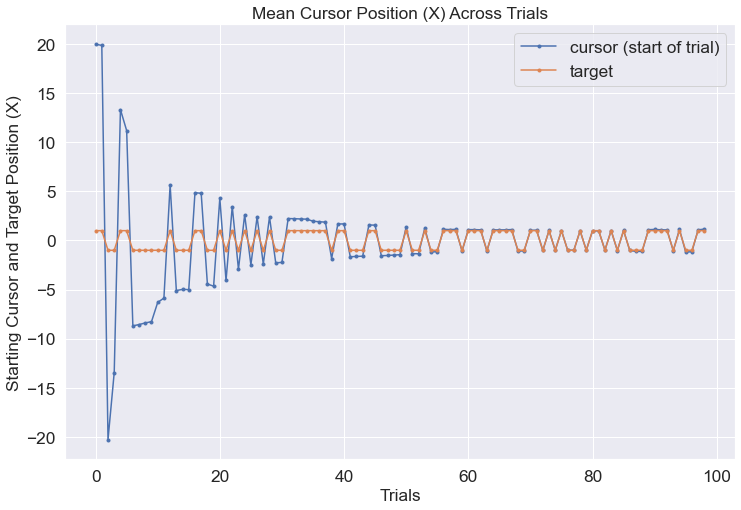

In [26]:
x = 0
y = 1
axm = NUM_DIM+1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=axm)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=axm)[x, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=axm)[x, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Mean Cursor Position (X) Across Trials',)
plt.show()


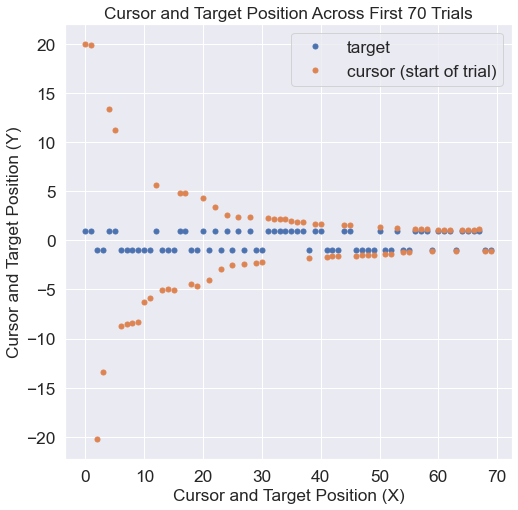

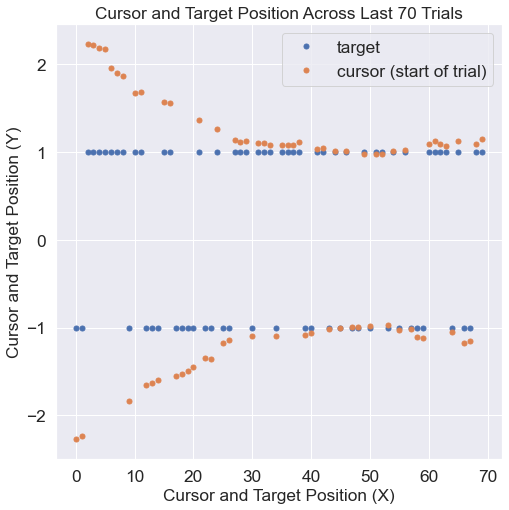

In [27]:
show_num = 70
plt.figure(figsize = (8, 8))
plt.plot(targ_x_mean[0:show_num], linestyle = '', marker = '.', markersize = 10, label = 'target' )
plt.plot(start_x_mean[0:show_num], linestyle = '', marker = '.', markersize = 10, label = 'cursor (start of trial)')
plt.legend()
plt.xlabel('Cursor and Target Position (X)')
plt.ylabel('Cursor and Target Position (Y)')
plt.title('Cursor and Target Position Across First ' + str(show_num) + ' Trials')
plt.show()

plt.figure(figsize = (8, 8))
plt.plot(targ_x_mean[-show_num:], linestyle = '', marker = '.', markersize = 10, label = 'target' )
plt.plot(start_x_mean[-show_num:], linestyle = '', marker = '.', markersize = 10, label = 'cursor (start of trial)')
plt.legend()
plt.xlabel('Cursor and Target Position (X)')
plt.ylabel('Cursor and Target Position (Y)')
plt.title('Cursor and Target Position Across Last ' + str(show_num) + ' Trials')
plt.show()


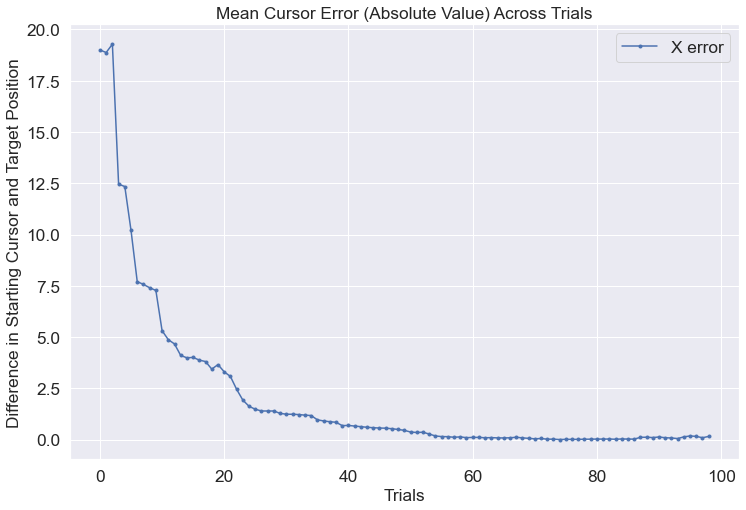

In [28]:
plt.figure(figsize = (12, 8))
plt.plot(np.abs(start_x_mean - targ_x_mean), linestyle = '-', marker = '.', label = 'X error')
# plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Mean Cursor Error (Absolute Value) Across Trials')
plt.show()

<ipython-input-30-e57d938dfbb1>:17: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(lk_mtx[0, 0, :]))


Text(0.5, 1.0, 'Log-10 of Mean KW')

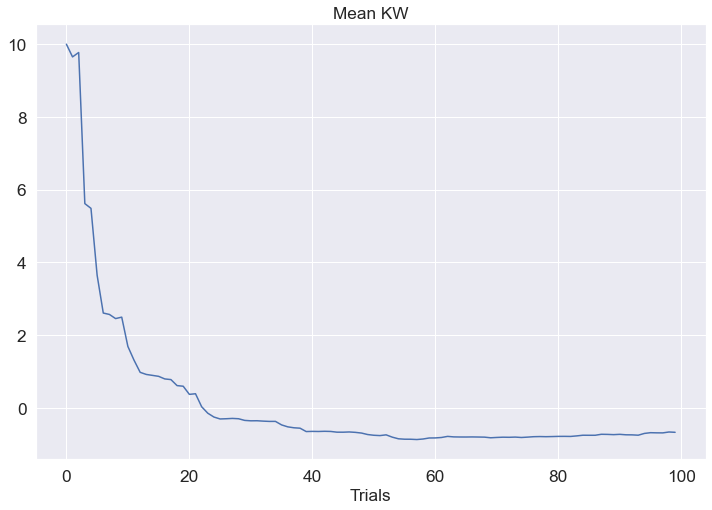

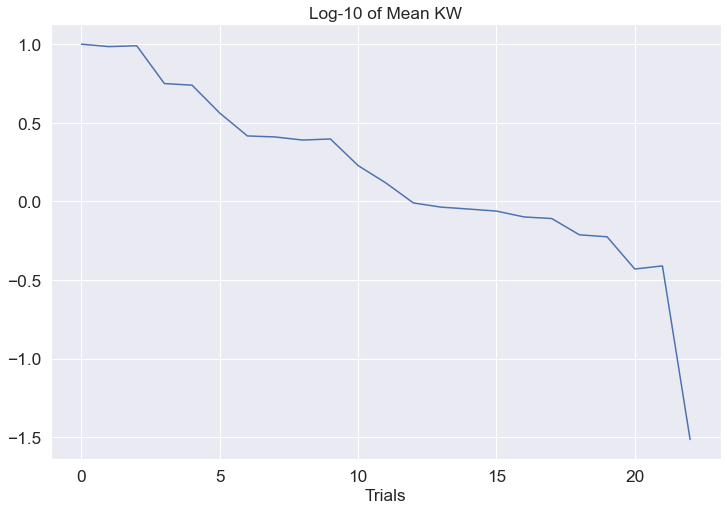

In [30]:
lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.plot(lk_mtx[0, 0, :])
plt.xlabel("Trials")
plt.title("Mean KW")

plt.figure(figsize = (12, 8))
plt.plot(np.log10(lk_mtx[0, 0, :]))
plt.xlabel("Trials")
plt.title("Log-10 of Mean KW")


Mean of Last KW = nan


/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Log-10 of Mean KW Matrix (0,0) | Last 100 Trials ')

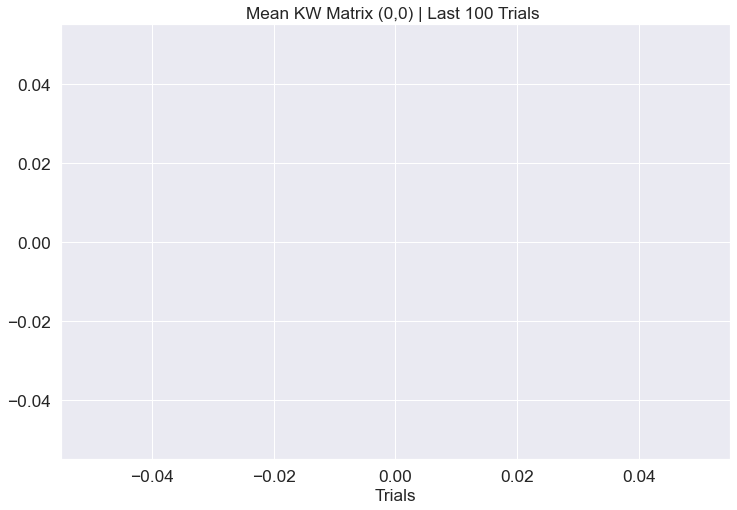

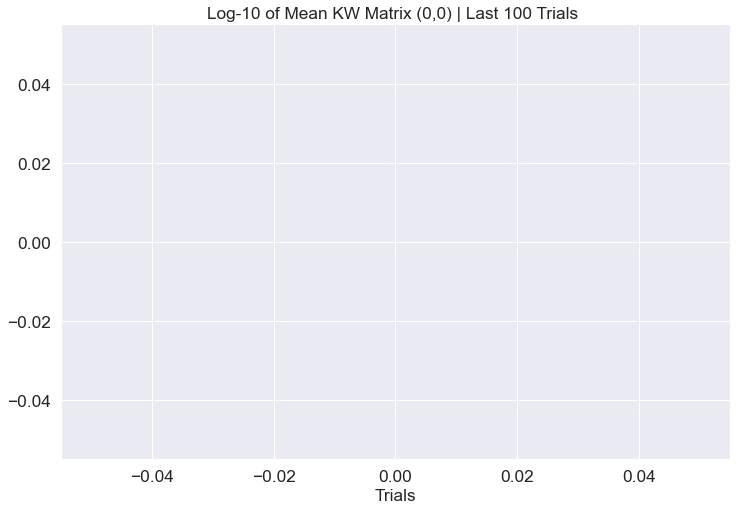

In [31]:
last = 100

plt.figure(figsize = (12, 8))
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.xlabel("Trials")
plt.title("Mean KW Matrix (0,0) | Last " + str(last) + " Trials ")

print("Mean of Last KW = "+ str(np.mean(lk_mtx[0, 0, NUM_TRIALS-last-1: NUM_TRIALS-1])))


plt.figure(figsize = (12, 8))
plt.plot(np.log10(lk_mtx[0, 0, NUM_TRIALS-1-last:NUM_TRIALS-1]))
plt.xlabel("Trials")
plt.title("Log-10 of Mean KW Matrix (0,0) | Last " + str(last) + " Trials ")


Text(0.5, 0, 'Trials')

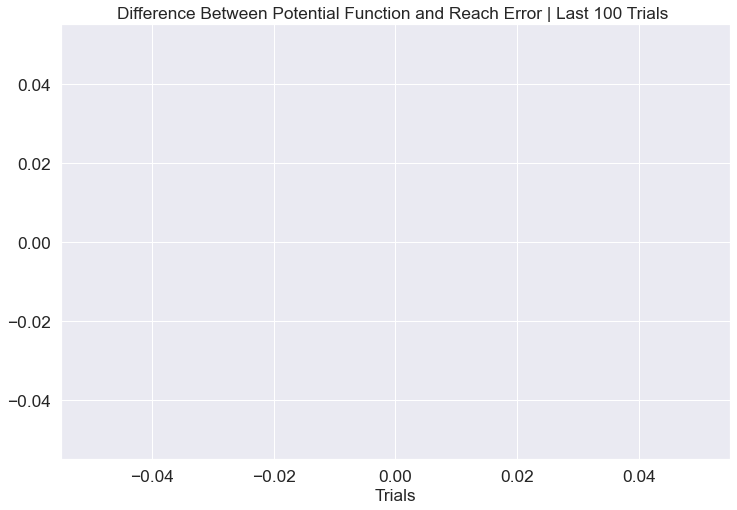

In [32]:
# looking at the last 
plt.figure(figsize = (12, 8))

for iS in range(NUM_SESSIONS):
    plt.plot(cost_endT[last:-1, iS] - re_cost[last:-1, iS])

plt.title("Difference Between Potential Function and Reach Error | Last " + str(last) + " Trials ")
plt.xlabel("Trials")

In [33]:
print("Average Cost Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| Cost (start) = " + str(np.mean(cost_startT[:last, iS])))
    print("Session # " + str(iS) + "| Cost (end) = " + str(np.mean(cost_startT[NUM_TRIALS-last-1:NUM_TRIALS-1, iS])))
    print("")
    
print("")
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| Reach Error (start) = " + str(np.mean(re_cost[:last, iS])))
    print("Session # " + str(iS) + "| Reach Error (end) = " + str(np.mean(re_cost[NUM_TRIALS-last-1:NUM_TRIALS-1, iS])))
    print("")


Average Cost Per Session:
Session # 0| Cost (start) = 51.47719277090442
Session # 0| Cost (end) = nan


Average Reach Error Per Session:
Session # 0| Reach Error (start) = 29.61745737734452
Session # 0| Reach Error (end) = nan



/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


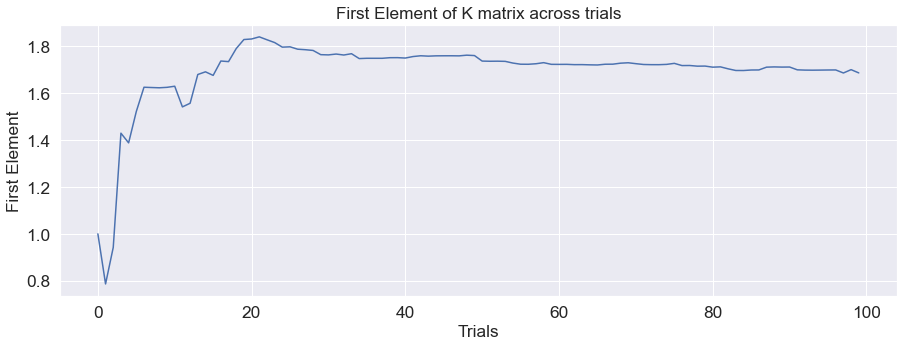

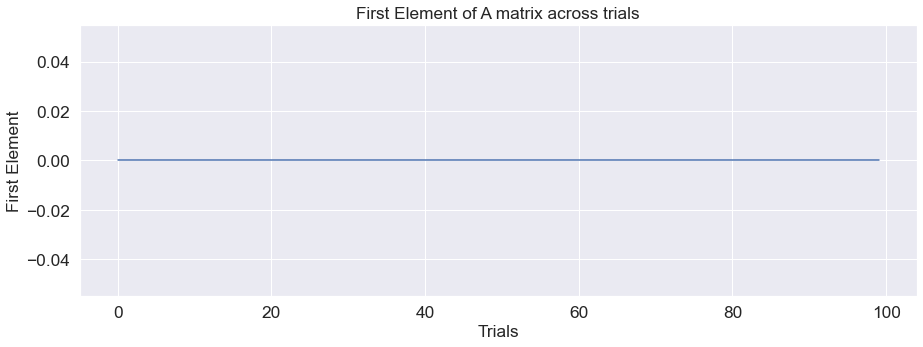

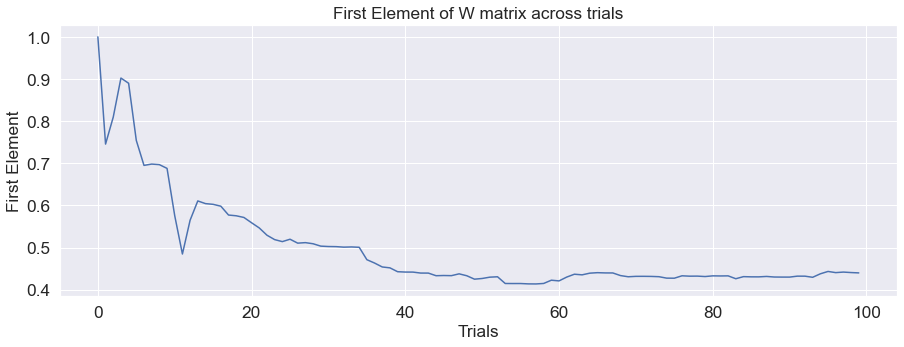

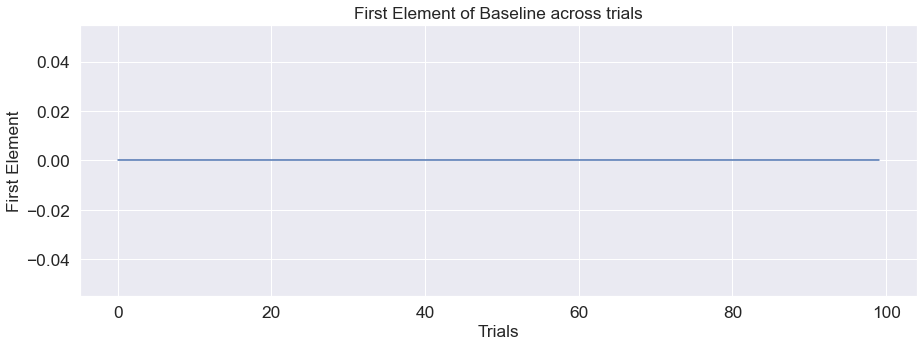

In [34]:
# plot of 1st dimension, neuron #1 and 1st session 

for iS in range(NUM_SESSIONS):
    plt.plot(k_trial[0, 0,:, iS]) #, label=''+sr(iS))
plt.title("First Element of K matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

for iS in range(NUM_SESSIONS):
    plt.plot(a_trial[0,:, iS]) #, label=''+sr(iS))
plt.title("First Element of A matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

for iS in range(NUM_SESSIONS):
    plt.plot(lambda_trial[0, 1, :, iS]) #, label=''+str(iS))
plt.title("First Element of W matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

for iS in range(NUM_SESSIONS):
    plt.plot(lambda_trial[0, 0,:, iS]) #, label=''+sr(iS))
plt.title("First Element of Baseline across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()




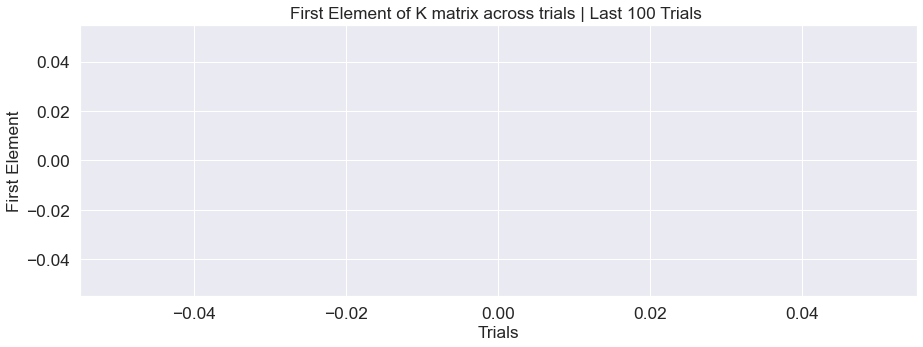

/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean of Last K = nan


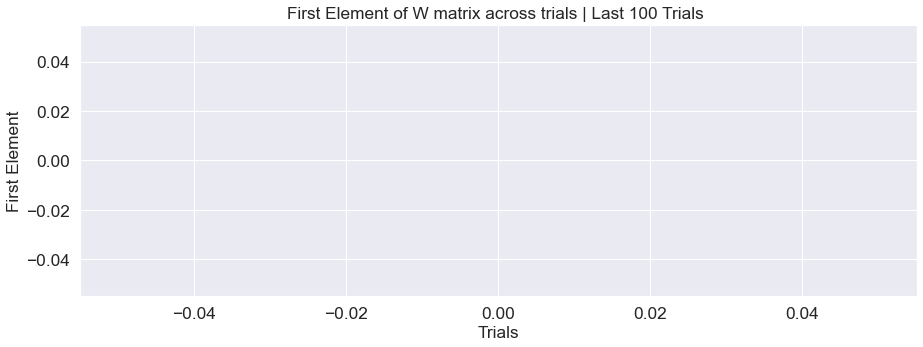

Mean of Last W = nan


/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mmadduri/.pyenv/versions/3.8.2/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
for iS in range(NUM_SESSIONS):
    plt.plot(k_trial[0, 0, NUM_TRIALS-last-1: NUM_TRIALS-1, iS]) #, label=''+sr(iS))
plt.title("First Element of K matrix across trials | Last " + str(last) + " Trials ")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

print("Mean of Last K = "+ str(np.mean(k_trial[0, 0, NUM_TRIALS-last-1: NUM_TRIALS-1,:])))

for iS in range(NUM_SESSIONS):
    plt.plot(lambda_trial[0, 1, NUM_TRIALS-last-1: NUM_TRIALS-1, iS]) #, label=''+str(iS))
plt.title("First Element of W matrix across trials | Last " + str(last) + " Trials ")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

print("Mean of Last W = "+ str(np.mean(lambda_trial[0, 1, NUM_TRIALS-last-1: NUM_TRIALS-1, :])))


Text(0.5, 1.0, 'Firing Rate Across Trials')

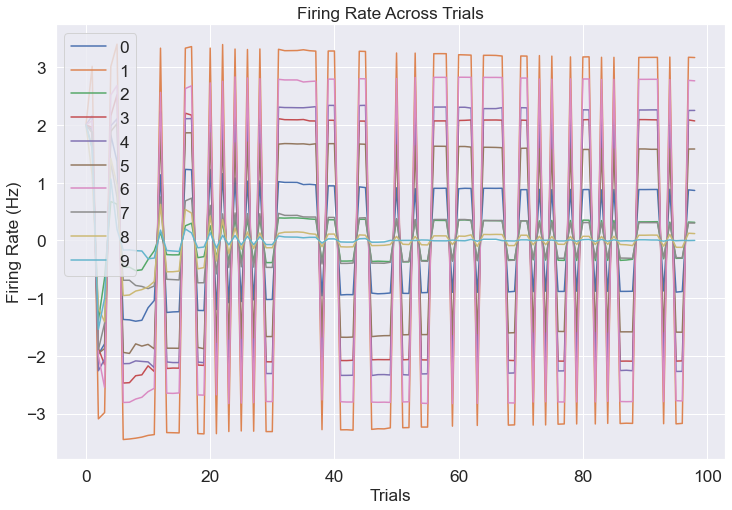

In [36]:
plt.figure(figsize = (12, 8))
for iN in range(NUM_NEURONS):
    plt.plot(fr_trial[iN, 0, :-1], label='' + str(iN))
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rate Across Trials')

In [37]:
DECODER_ADAPT

True

In [38]:
BRAIN_ADAPT

True

### Stationary Point Analysis

$$ k_0 = \sqrt{-\frac{\sigma}{\tau^2} + 1} $$
$$ w_0 = \sqrt{-\frac{\sigma}{\tau^2} + 1} $$

$$ k_0w_0 = 1 -\frac{\sigma}{\tau^2} $$

With $\sigma = \frac{1}{2}$ and $\tau = 1$
$$ k_0w_0 = \frac{1}{2} $$




In [ ]:
sigma_dist = SIGMA_GAUSSIAN
mu = 0

s = np.random.normal(mu, sigma_dist, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma_dist * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma_dist**2) ),
         linewidth=2, color='r')
plt.show()


In [ ]:
# calcNextDecoder(decoder_params, brain_vars, cost_func


# # This function goes through and updates brain paramters over the num_iter times
# def calcNextBrain(brain_params, decoder_params, cost_func, targ_vect, num_iter):
#     # Unpack arguments that are being passed in
#     (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
# #     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
#     (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
#     decoder_vals = (a_vect, k_matx)
# #     grad_args_init = (decoder_vals, fr_init)
    
#     num_neurons = np.size(fr_init, 0)
#     fr_vect = np.zeros( (num_neurons, 1, num_iter) )
#     fr_final = np.zeros( np.size(fr_init) )
#     fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
#     # lambda init = N x 3
#     # lambda_vect = N x 3 X ITER
#     lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
#     lambda_vect[:, :, 0] = lambda_init 
#     lambda_final = np.zeros(np.size(lambda_init))
    
#     for iT in range(num_iter-1):
#         # (1) calculate the perturbation
#         brain_vars = (fr_vect[:, :, iT], targ_vect, lambda_vect[:,:, iT])
#         grad_args = (decoder_vals, brain_vars)
#         grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, cost_func, grad_args)
       
#         # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
#         lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
#         lambda_vect[:,:, iT + 1] = lambda_next
       
#         # (3) fr+ = B(lambda+)
#         fr_next = brainFiringRate(lambda_next, targ_vect)
#         fr_vect[:, :, iT + 1] = fr_next
       
#     lambda_final = lambda_next
#     fr_final = fr_next

#     return  (fr_final, lambda_final)